# ATOC5860 - power_spectra_game - Lecture #9
### Coded by Libby Barnes (CSU), updating and conversion to a game by Jennifer Kay (CU)
### works with python environment atoc5860env2023clean
### Last updated March 12, 2024

Game time: Can you detect the power at a specific frequency over the red noise null hypothesis? Have fun. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import scipy.signal as sig
import scipy.stats as stats
from matplotlib.gridspec import GridSpec
## needed in ipython notebooks to make plots appear in-line

In [2]:
### input parameters for creation of synthetic data set: red noise with oscillation

T = 256                #length of window (default 256 timesteps)
alpha = 0.5            #red noise lag-one autocorrelation (default 0.5, try increasing to 0.9 or decreasing to 0.1)
xcosamp = 0.5          #amplitude of oscillation (default 0.5, try increasing to 5 or decreasing to 0.1)
xcosfreq = (50./256.)  #frequency of oscillation (default 50./256., try 10./256. or 100./256.)
print('frequency of oscillation (per timestep):',xcosfreq)

frequency of oscillation (per timestep): 0.1953125


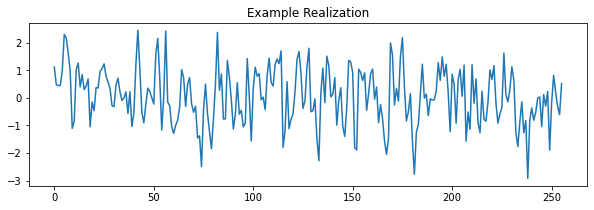

In [3]:
# Example realization - red noise with oscillation with white noise applied to amplitude/frequency
fig=plt.figure(figsize=(10,3))
factor = np.sqrt(1.-alpha*alpha)
x = np.zeros(T,)
x[0] = x[-1]*alpha + factor*np.random.randn() 
for j in np.arange(1,T,1):
    x[j] = x[j-1]*alpha + factor*np.random.randn()+xcosamp*np.cos(2.*np.pi*(1.-0.01*np.random.randn())*xcosfreq*j)
    ### use the code below if you only want the noise to applied to the amplitude, not the frequency
    x[j] = x[j-1]*alpha + factor*np.random.randn()+xcosamp*np.cos(2.*np.pi*xcosfreq*j)
plt.plot(x);
plt.title('Example Realization');

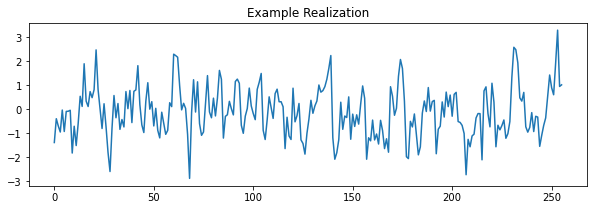

In [4]:
# Example realization - red noise with oscillation with white noise applied to amplitude/frequency
fig=plt.figure(figsize=(10,3))
factor = np.sqrt(1.-alpha*alpha)
x = np.zeros(T,)
x[0] = x[-1]*alpha + factor*np.random.randn() 
for j in np.arange(1,T,1):
    ### use the code with the noise to applied to the amplitude, not the frequency
    x[j] = x[j-1]*alpha + factor*np.random.randn()+xcosamp*np.cos(2.*np.pi*xcosfreq*j)
plt.plot(x);
plt.title('Example Realization');

In [5]:
### spectral analysis parameters
T2 = T/2                      #number of spectral estimates
freq = np.arange(0.,T2+1.)/T  #frequency of spectral estimates

### construct the expected rednoise spectrum (this is your null hypothesis)
rspec = []
for i in np.arange(1,T2+2,1):
    rspec.append((1.-alpha*alpha)/(1.-2.*alpha*np.cos(np.pi*(i-1.)/T2)+alpha*alpha))

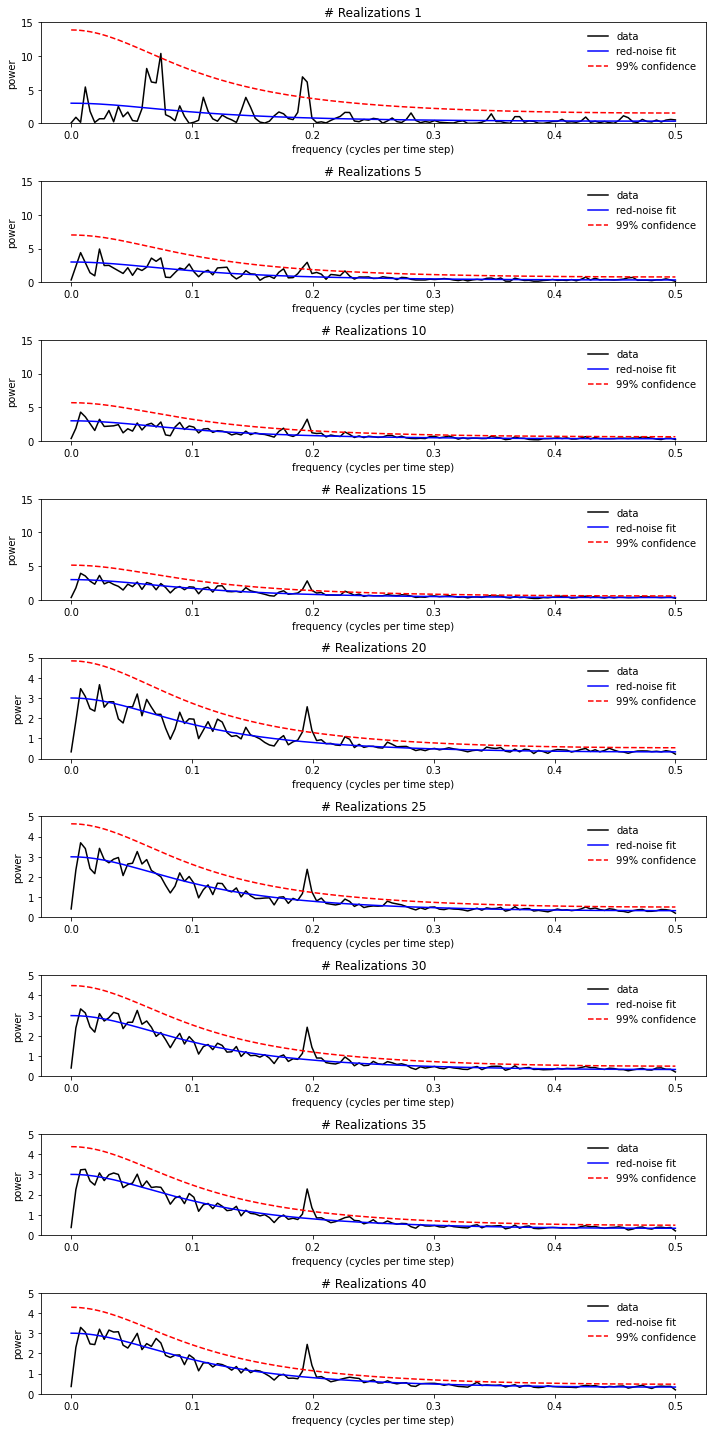

In [6]:
## Now you are ready to play!!

## Look at N number of realizations of randomly generated data with weak spectral power
## See if any statistically significant peaks are detected
## Does this remind you of application lab #2?
## Instead of "fishing for correlation" we are now are fishing for statistically significant peaks" 
## and also seeing the influence of increasing the number of realizations we are using on this fishing expedition.

## note: the more realizations (larger N) the easier it is to detect the peak
## note: the redder the timeseries (larger alpha) the easier it is to detect the peak
## note: the larger the amplitude of the peak (larger xcosamp) the easier it is to detect the peak

# loop through N realizations - plot results
N = 40    #number of realizations (default 40)

## plotting set-up
nplots=round(N/5)+1
gs=GridSpec(nplots,1)
foo=0
fig=plt.figure(figsize=(10,20))

for ir in np.arange(0,N,1): 
    ## generate random timeseries with weak spectral power
    x[0] = x[-1]*alpha + factor*np.random.randn() 
    for j in np.arange(1,T,1):
        x[j] = x[j-1]*alpha + factor*np.random.randn()+xcosamp*np.cos(2.*np.pi*(1.-0.01*np.random.randn())*xcosfreq*j)
    ## calculate the power spectra using Welch's method
    ## see https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.welch.html   
    #### Hamming or Hanning window?  Both are tapered windows. Unlike the Hamming window, 
    ### the end points of the Hannning window just touch zero. This provides a slightly more optimal 
    ##reduction in the side lobes and slightly more smoothing of the central lobe.
    #p = sig.welch(x,window='hanning',nperseg=T);
    p = sig.welch(x,window='hamming',nperseg=T);
    if(ir==0):
        psum = p[1]
    else:
        psum = psum + p[1]
    # calculate average    
    pave = psum/(ir+1.0)
    #normalize the spectrum
    pave = pave/np.mean(pave)
    #calculate significance
    dof = 2.*(ir+1.)
    fstat = stats.f.ppf(.99,dof,1000)
    spec99 = [fstat*m for m in rspec]
    if((ir+1.) % 5 == 0 or ir==0):       ## "(ir+1.) % 5" means is (ir+1.) divisible by 5 
        plt.subplot(gs[foo,0])
        plt.xlabel('frequency (cycles per time step)')
        plt.ylabel('power')
        plt.title('# Realizations ' + str(ir+1))
        if(ir<15):
            plt.ylim(0,15.)
        else:
            plt.ylim(0,5.)            
        plt.plot(freq,pave,'-k', label = 'data');
        plt.plot(freq,rspec,'-', label = 'red-noise fit', color = 'blue');
        plt.plot(freq,spec99,'--', label = '99% confidence', color = 'red');
        plt.legend(frameon = False);
        foo=foo+1
        #print(foo)
        fig.tight_layout()